# Imports and downloading dataset

In [1]:
import os
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import numpy as np
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
from scipy.io import wavfile
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.layers import Dense
import tensorflow
import tensorflow.keras
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, LeakyReLU
from keras.utils import np_utils
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping
from sklearn.metrics import confusion_matrix
from scipy import stats
from sklearn.preprocessing import OneHotEncoder

import keras
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization,MaxPooling1D,GlobalMaxPooling1D
import seaborn as sns
import random
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [2]:
from keras import backend as K
K._get_available_gpus()

['/device:GPU:0']

In [3]:
from google.colab import drive

drive.mount("/content/drive")
DATASET_PATH = "/content/drive/MyDrive/Kaggle_ds/Crema/" # Crema dataset

Mounted at /content/drive


In [4]:
os.environ["KAGGLE_CONFIG_DIR"] = "/content/drive/MyDrive/Kaggle_ds"

In [5]:
if not os.path.exists("/content/drive/MyDrive/Kaggle_ds/"):
    os.makedirs("/content/drive/MyDrive/Kaggle_ds/")

In [6]:
if len(os.listdir(os.environ["KAGGLE_CONFIG_DIR"])) == 1:
    !kaggle datasets download -d dmitrybabko/speech-emotion-recognition-en -p /content/drive/MyDrive/Kaggle_ds --unzip

In [7]:
%ls "/content/drive/MyDrive/Kaggle_ds"

1d_augmented.best.hdf5  kaggle.json                weight.best.hdf5
Crema/                  Ravdess/                   weightnoise.best.hdf5
Crema_old/              Savee/                     weightscaled.best.hdf5
features/               Tess/                      weightstretch.best.hdf5
features2/              weightaugmented.best.hdf5


In [8]:
# Get all filenames into a list
dir_list: list[str] = os.listdir(DATASET_PATH)
dir_list.sort()
dir_list[:5]

['1001_DFA_ANG_XX.wav',
 '1001_DFA_DIS_XX.wav',
 '1001_DFA_FEA_XX.wav',
 '1001_DFA_HAP_XX.wav',
 '1001_DFA_NEU_XX.wav']

In [9]:
emotion_mapping: dict[str, str] = {
    "SAD": "sad",
    "ANG": "angry",
    "DIS": "disgust",
    "FEA": "fear",
    "HAP": "happy",
    "NEU": "neutral",
}
female_ids: list[int] = [
    1002,1003,1004,1006,1007,1008,1009,1010,1012,1013,1018,1020,1021,
    1024,1025,1028,1029,1030,1037,1043,1046,1047,1049,1052,1053,1054,
    1055,1056,1058,1060,1061,1063,1072,1073,1074,1075,1076,1078,1079,
    1082,1084,1089,1091,
]


def get_labels_crema(
    file_list, mapping, female_ids
) -> tuple[list[str], list[str], list[str]]:
    emotion: list[str] = []
    gender: list[str] = []
    path: list[str] = []

    for filename in file_list:
        path.append(filename)
        filename = filename.split("_")
        emotion.append(mapping[filename[2]])
        gender.append("female" if int(filename[0]) in female_ids else "male")
    return emotion, gender, path


emotion, gender, path = get_labels_crema(
    dir_list, mapping=emotion_mapping, female_ids=female_ids
)

In [10]:
CREMA_df = pd.DataFrame(emotion, columns=["emotion"])
CREMA_df = pd.concat([CREMA_df, pd.DataFrame(gender, columns=["gender"])], axis=1)
CREMA_df = pd.concat([CREMA_df, pd.DataFrame(path, columns=["path"])], axis=1)
CREMA_df["source"] = "CREMA"

In [11]:
CREMA_df.head()

,emotion,gender,path,source
0,angry,male,1001_DFA_ANG_XX.wav,CREMA
1,disgust,male,1001_DFA_DIS_XX.wav,CREMA
2,fear,male,1001_DFA_FEA_XX.wav,CREMA
3,happy,male,1001_DFA_HAP_XX.wav,CREMA
4,neutral,male,1001_DFA_NEU_XX.wav,CREMA


In [12]:
CREMA_df_summary = CREMA_df.pivot_table(
    index="emotion", columns="gender", aggfunc=len, values="source"
)
CREMA_df_summary

gender,female,male
emotion,,
angry,600,671
disgust,600,671
fear,600,671
happy,600,671
neutral,512,575
sad,600,671


<Axes: ylabel='emotion'>

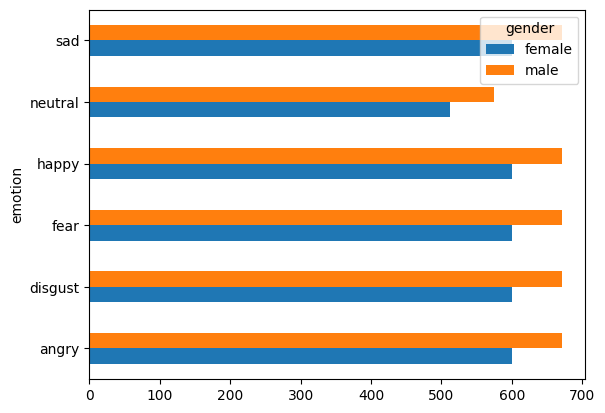

In [13]:
CREMA_df_summary.plot(kind="barh")

1089_TSI_NEU_XX.wav


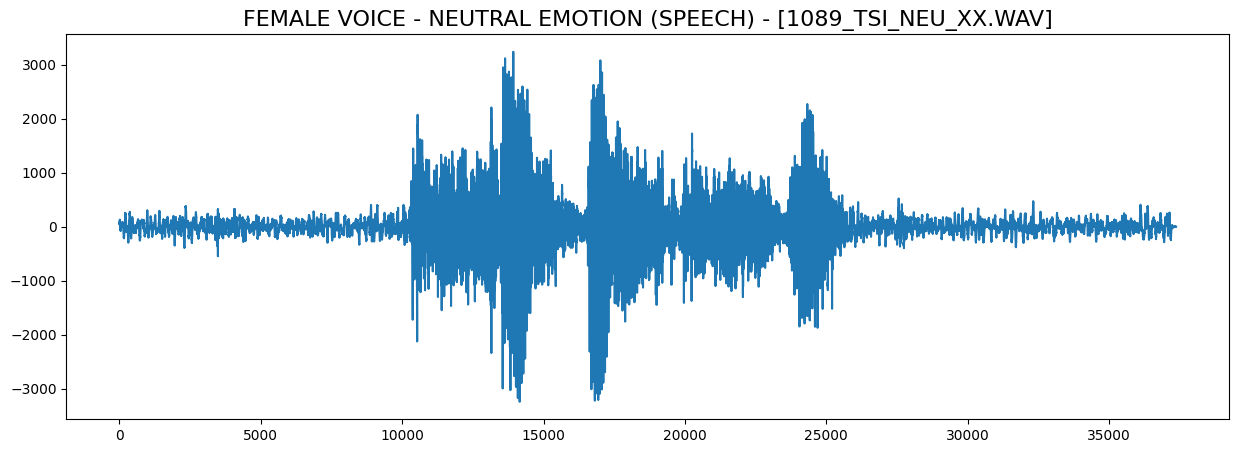

In [14]:
np.random.seed(SEED)
n_files = len(dir_list)

# choose random number
rnd = np.random.randint(0, n_files)

# use the Librosa library to load and plot the random speech

fname = CREMA_df.path[rnd]
print(fname)
sampling_rate, data = wavfile.read(DATASET_PATH + fname)

plt.figure(figsize=(15, 5))
info = CREMA_df.iloc[rnd].values
title_txt = f"{info[1]} voice - {info[0]} emotion (speech) - [{fname}]"
plt.title(title_txt.upper(), size=16)
plt.plot(data)

# play the audio
ipd.Audio(DATASET_PATH + fname)

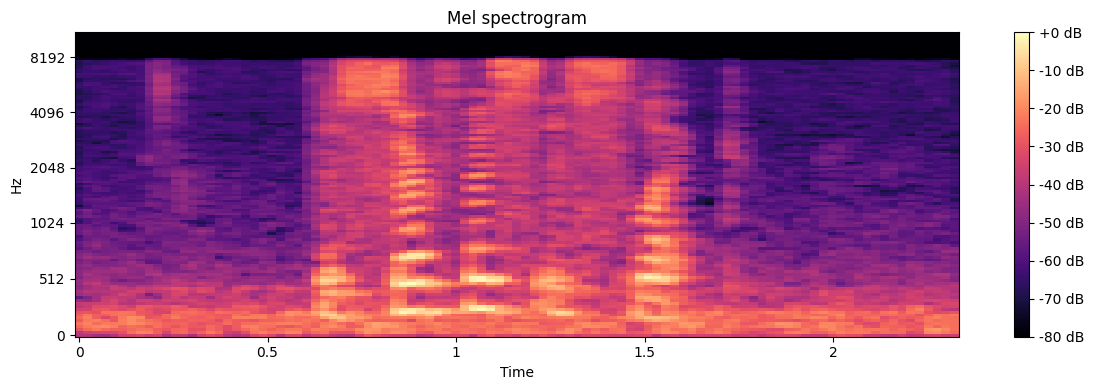

In [15]:
y, sr = librosa.load(DATASET_PATH + fname)

# Compute mel spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)

# Convert to log scale (dB) using the peak power as reference
log_S = librosa.power_to_db(S, ref=np.max)

# Plot mel spectrogram
plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sr, x_axis="time", y_axis="mel")
plt.title("Mel spectrogram")
plt.colorbar(format="%+02.0f dB")
plt.tight_layout()
plt.show()

# Feature extraction

Feature extraction:
Kerkeni, Leila and Serrestou, Youssef and Raoof, Kosai and Cleder, ´
Catherine and Mahjoub, Mohamed and Mbarki, Mohamed, “Automatic
Speech Emotion Recognition Using Machine Learning,” March, 2019.
https://www.intechopen.com/chapters/65993

## Functions

In [16]:
!pip install git+https://github.com/detly/gammatone.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/detly/gammatone.git to /tmp/pip-req-build-sqq5i19n
  Running command git clone --filter=blob:none --quiet https://github.com/detly/gammatone.git /tmp/pip-req-build-sqq5i19n
  Resolved https://github.com/detly/gammatone.git to commit 0626328ef7c31d3b33214db2fdcd52e8601eb4c5
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 5.0 MB/s eta 0:00:00
  Created wheel for Gammatone: filename=Gammatone-1.0-py3-none-any.whl size=21759 sha256=b934faa8d2174389a02c4056b00540ba97136ae047a2d52fea3252dcc71f3211
  Stored in directory: /tmp/pip-ephem-wheel-cache-i60x_sno/wheels/1d/b4/36/1a03814cb85dffddc9345619ba6536cad7c21ae9820107fac6
Successfully built Gammatone


In [17]:
from gammatone.filters import make_erb_filters, erb_filterbank, erb_space
from scipy.signal import hilbert, butter, sosfiltfilt

In [18]:
def get_features_paper(filenames, n_mfcc: int = 12, n_mels: int = 19, n_modulation_filters: int = 5):
    np.random.seed(SEED)
    random.seed(SEED)
    all_features = np.empty((len(filenames), (n_mfcc * 5 + n_mels * n_modulation_filters)))
    for i, filename in enumerate(filenames):
        if i % 100 == 0:
            print(f"{i}/{len(filenames)}")

        y, sr = librosa.load(DATASET_PATH+filename)

        # Extract the MFCC features
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        # Calculate the statistical measures for each MFCC coefficient
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_var = np.var(mfcc, axis=1)
        mfcc_std = np.std(mfcc, axis=1)
        mfcc_kurtosis = stats.kurtosis(mfcc, axis=1)
        mfcc_skewness = stats.skew(mfcc, axis=1)
        # Concatenate the MFCC statistical measures into a single feature vector
        mfcc_features = np.hstack([mfcc_mean, mfcc_var, mfcc_std, mfcc_kurtosis, mfcc_skewness])

        # Decompose the speech signal using an auditory filter bank with n_mels filters
        cf = erb_space(20, sr/2, n_mels)
        b = make_erb_filters(sr, cf)
        filtered_signals = erb_filterbank(y, b)

        # Compute the Hilbert envelopes of the critical-band outputs
        hilbert_envelopes = np.abs(hilbert(filtered_signals))

        # Apply a modulation filter bank with n_modulation_filters filters to the Hilbert envelopes
        low_freq = 1
        high_freq = 10
        modulation_spectra = []
        for i in range(n_modulation_filters):
            # Design a bandpass filter for each modulation frequency band
            low = low_freq + i * (high_freq - low_freq) / n_modulation_filters
            high = low_freq + (i + 1) * (high_freq - low_freq) / n_modulation_filters
            sos = butter(4, [low / (sr / 2), high / (sr / 2)], 'band', output='sos')
            # Apply the bandpass filter to each Hilbert envelope
            filtered_envelopes = sosfiltfilt(sos, hilbert_envelopes)
            # Calculate the modulation spectrum by taking the mean of the filtered envelopes along the time axis
            modulation_spectrum = np.mean(filtered_envelopes, axis=1)
            modulation_spectra.append(modulation_spectrum)

        # Concatenate all modulation spectra into a single feature vector
        msf_features = np.hstack(modulation_spectra)


        # Concatenate the MFCC and MSF features into a single feature vector
        feature_vector = np.hstack([mfcc_features, msf_features])
        all_features[i] = feature_vector

    
    # Define the column names for the MFCC features
    mfcc_column_names = []
    for stat in ["mean", "var", "std", "kurtosis", "skewness"]:
        for i in range(n_mfcc):
            mfcc_column_names.append(f"mfcc{i+1}_{stat}")

    # Define the column names for the MSF features
    msf_column_names = [f'MSF_{i}' for i in range(1, n_mels * n_modulation_filters + 1)]
    column_names = mfcc_column_names + msf_column_names
    # Set the column names of the DataFrame
    all_features = pd.DataFrame(all_features, columns=column_names)
    
    return all_features

## Run

In [ ]:
EXIT
# if you intended to run this section, remove this codeblock

In [26]:
df_features = get_features_paper(CREMA_df["path"])

0/7442
100/7442
200/7442
300/7442
400/7442
500/7442
600/7442
700/7442
800/7442
900/7442
1000/7442
1100/7442
1200/7442
1300/7442
1400/7442
1500/7442
1600/7442
1700/7442
1800/7442
1900/7442
2000/7442
2100/7442
2200/7442
2300/7442
2400/7442
2500/7442
2600/7442
2700/7442
2800/7442
2900/7442
3000/7442
3100/7442
3200/7442
3300/7442
3400/7442
3500/7442
3600/7442
3700/7442
3800/7442
3900/7442
4000/7442
4100/7442
4200/7442
4300/7442
4400/7442
4500/7442
4600/7442
4700/7442
4800/7442
4900/7442
5000/7442
5100/7442
5200/7442
5300/7442
5400/7442
5500/7442
5600/7442
5700/7442
5800/7442
5900/7442
6000/7442
6100/7442


<ipython-input-25-024382089adf>:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  mfcc_kurtosis = stats.kurtosis(mfcc, axis=1)
<ipython-input-25-024382089adf>:18: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  mfcc_skewness = stats.skew(mfcc, axis=1)


6200/7442
6300/7442
6400/7442
6500/7442
6600/7442
6700/7442
6800/7442
6900/7442
7000/7442
7100/7442
7200/7442
7300/7442
7400/7442


In [28]:
df_features.head()

,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,mfcc9_mean,mfcc10_mean,...,MSF_86,MSF_87,MSF_88,MSF_89,MSF_90,MSF_91,MSF_92,MSF_93,MSF_94,MSF_95
0,1.390495e-315,6.899955e-310,1.390495e-315,7.425465e-316,-9.753901e-18,-2.733477e-17,-6.308920e-17,-1.293858e-16,-2.441448e-16,-4.323459e-16,...,-1.010632e-10,-1.034859e-10,-1.059542e-10,-1.084688e-10,-1.110304e-10,-1.136396e-10,-1.162972e-10,-1.190036e-10,-1.217598e-10,-1.245663e-10
1,-1.274237e-10,-1.303330e-10,-1.332946e-10,-1.363093e-10,-1.393779e-10,-1.425010e-10,-1.456794e-10,-1.489138e-10,-1.522048e-10,-1.555533e-10,...,-1.520082e-09,-1.539852e-09,-1.559813e-09,-1.579963e-09,-1.600306e-09,-1.620841e-09,-1.641569e-09,-1.662492e-09,-1.683611e-09,-1.704927e-09
2,-1.726441e-09,-1.748154e-09,-1.770066e-09,-1.792180e-09,-1.814496e-09,-1.837015e-09,-1.859738e-09,-1.882667e-09,-1.905802e-09,-1.929144e-09,...,-7.451626e-09,-7.512191e-09,-7.573080e-09,-7.634291e-09,-7.695827e-09,-7.757688e-09,-7.819874e-09,-7.882385e-09,-7.945222e-09,-8.008385e-09
3,-8.071875e-09,-8.135693e-09,-8.199838e-09,-8.264311e-09,-8.329113e-09,-8.394243e-09,-8.459703e-09,-8.525493e-09,-8.591612e-09,-8.658063e-09,...,-2.082368e-08,-2.093561e-08,-2.104785e-08,-2.116039e-08,-2.127324e-08,-2.138639e-08,-2.149985e-08,-2.161360e-08,-2.172766e-08,-2.184203e-08
4,-4.683947e+02,1.308014e+02,1.401454e+01,5.554595e+01,-1.316649e+01,4.146703e+01,-1.579575e+01,1.558392e+01,-7.546881e+00,1.097805e+01,...,1.544299e-07,-4.492279e-07,9.455538e-07,1.624411e-06,3.370852e-07,1.891161e-07,2.485882e-06,-9.138433e-07,4.897749e-07,8.629205e-08


In [27]:
df_features.to_feather("/content/drive/MyDrive/Kaggle_ds/features/paper_features.feather")

# Loading features

In [19]:
df_features = pd.read_feather("/content/drive/MyDrive/Kaggle_ds/features/paper_features.feather")

In [20]:
df_features.head()

,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,mfcc9_mean,mfcc10_mean,...,MSF_86,MSF_87,MSF_88,MSF_89,MSF_90,MSF_91,MSF_92,MSF_93,MSF_94,MSF_95
0,1.390495e-315,6.899955e-310,1.390495e-315,7.425465e-316,-9.753901e-18,-2.733477e-17,-6.308920e-17,-1.293858e-16,-2.441448e-16,-4.323459e-16,...,-1.010632e-10,-1.034859e-10,-1.059542e-10,-1.084688e-10,-1.110304e-10,-1.136396e-10,-1.162972e-10,-1.190036e-10,-1.217598e-10,-1.245663e-10
1,-1.274237e-10,-1.303330e-10,-1.332946e-10,-1.363093e-10,-1.393779e-10,-1.425010e-10,-1.456794e-10,-1.489138e-10,-1.522048e-10,-1.555533e-10,...,-1.520082e-09,-1.539852e-09,-1.559813e-09,-1.579963e-09,-1.600306e-09,-1.620841e-09,-1.641569e-09,-1.662492e-09,-1.683611e-09,-1.704927e-09
2,-1.726441e-09,-1.748154e-09,-1.770066e-09,-1.792180e-09,-1.814496e-09,-1.837015e-09,-1.859738e-09,-1.882667e-09,-1.905802e-09,-1.929144e-09,...,-7.451626e-09,-7.512191e-09,-7.573080e-09,-7.634291e-09,-7.695827e-09,-7.757688e-09,-7.819874e-09,-7.882385e-09,-7.945222e-09,-8.008385e-09
3,-8.071875e-09,-8.135693e-09,-8.199838e-09,-8.264311e-09,-8.329113e-09,-8.394243e-09,-8.459703e-09,-8.525493e-09,-8.591612e-09,-8.658063e-09,...,-2.082368e-08,-2.093561e-08,-2.104785e-08,-2.116039e-08,-2.127324e-08,-2.138639e-08,-2.149985e-08,-2.161360e-08,-2.172766e-08,-2.184203e-08
4,-4.683947e+02,1.308014e+02,1.401454e+01,5.554595e+01,-1.316649e+01,4.146703e+01,-1.579575e+01,1.558392e+01,-7.546881e+00,1.097805e+01,...,1.544299e-07,-4.492279e-07,9.455538e-07,1.624411e-06,3.370852e-07,1.891161e-07,2.485882e-06,-9.138433e-07,4.897749e-07,8.629205e-08


# Data splitting

In [21]:
lb = LabelEncoder()
CREMA_df["emotion"] = lb.fit_transform(CREMA_df["emotion"])
for i in range(len(lb.classes_)):
    print(f'Label {lb.classes_[i]} mapped to {i}')

Label angry mapped to 0
Label disgust mapped to 1
Label fear mapped to 2
Label happy mapped to 3
Label neutral mapped to 4
Label sad mapped to 5


In [96]:
X_train_val, X_test, y_train_val, y_test = train_test_split(df_features, CREMA_df["emotion"], test_size=0.3, random_state=SEED, stratify=CREMA_df["emotion"], shuffle=True)
# Split the remaining data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=SEED, stratify=y_train_val, shuffle=True)
print(len(X_train))
print(len(X_val))
print(len(X_test))

4688
521
2233


### One-Hot encoding labels

In [97]:
y_train_oe = np_utils.to_categorical(y_train)
y_val_oe = np_utils.to_categorical(y_val)
y_test_oe = np_utils.to_categorical(y_test)

# Speaker Normalization

In [98]:
# Calculate the mean and standard deviation of each feature column using only the training data
mean = X_train.mean()
std = X_train.std()

# Normalize the features in the training, validation and testing sets
X_train_normalized = (X_train - mean) / std
X_val_normalized = (X_val - mean) / std
X_test_normalized = (X_test - mean) / std

# Model callbacks

In [59]:
def get_f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [60]:
# call back function after epoch end for storing accuracy and loss and f1 score trainig and validation
class myCallback(tensorflow.keras.callbacks.Callback):
    accuracy = []
    val_accuracy = []
    loss = []
    val_loss = []
    f1 = []
    val_f1 = []
    epoch_num = 0
    def __init__(self, logs={}):
        self.accuracy = []
        self.val_accuracy = []
        self.loss = []
        self.val_loss = []
        self.f1 = []
        self.val_f1 = []
        self.epoch_num = 0

    def on_epoch_end(self,epoch,logs={}):
        # get current accuracy and loss
        current_accuracy = logs.get('accuracy')
        current_val_accuracy = logs.get('val_accuracy')
        current_loss = logs.get('loss')
        current_val_loss = logs.get('val_loss')
        current_f1 = logs.get('get_f1')
        current_val_f1 = logs.get('val_get_f1')

        # append current accuracy and loss to lists
        self.accuracy.append(current_accuracy)
        self.val_accuracy.append(current_val_accuracy)
        self.loss.append(current_loss)
        self.val_loss.append(current_val_loss)
        self.f1.append(current_f1)
        self.val_f1.append(current_val_f1)

        # update epoch number
        self.epoch_num = self.epoch_num + 1

# Model

In [71]:
def create_model():
    model=Sequential()
    model.add(Conv1D(32, kernel_size=21, strides=1, padding='same', activation='relu', input_shape=(X_train_normalized.shape[1], 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
  
    model.add(Conv1D(64, kernel_size=19, strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))

    model.add(Conv1D(128, kernel_size=17, strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))

    model.add(Conv1D(256, kernel_size=15, strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))

    model.add(Conv1D(512, kernel_size=13, strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))

    model.add(Conv1D(1024, kernel_size=11, strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))

    model.add(Conv1D(1024, kernel_size=9, strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(GlobalMaxPooling1D())

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
  
    model.add(Dense(6, activation='softmax'))
    opt=tensorflow.keras.optimizers.Adam(
      learning_rate=0.001
  )
    model.compile(loss = 'categorical_crossentropy',optimizer ='Adam',metrics = ['accuracy',get_f1])
    return model


# Training

In [81]:
# train model
model = create_model()
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=20, min_lr=0.000001)
save_metric = myCallback()
es = EarlyStopping(monitor='val_accuracy', patience=80)
filepath="/content/drive/MyDrive/Kaggle_ds/paper_1d_normal.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

tensorflow.convert_to_tensor(X_train_normalized, dtype=tensorflow.float32)
cnn_results=model.fit(X_train_normalized, y_train_oe,  
                      batch_size=64,
                      epochs=1000,
                      validation_data = (X_val_normalized,y_val_oe),
                      callbacks=[lr_reduce,checkpoint,es,save_metric])

Epoch 1/1000
 5/74 [=>............................] - ETA: 3s - loss: 4.5873 - accuracy: 0.1719 - get_f1: 0.1279

73/74 [============================>.] - ETA: 0s - loss: 2.2411 - accuracy: 0.1704 - get_f1: 0.0334
Epoch 1: val_accuracy improved from -inf to 0.17658, saving model to /content/drive/MyDrive/Kaggle_ds/paper_1d_normal.best.hdf5
74/74 [==============================] - 11s 55ms/step - loss: 2.2398 - accuracy: 0.1704 - get_f1: 0.0329 - val_loss: 1.8714 - val_accuracy: 0.1766 - val_get_f1: 0.0000e+00 - lr: 0.0010
Epoch 2/1000
73/74 [============================>.] - ETA: 0s - loss: 1.8855 - accuracy: 0.1605 - get_f1: 0.0049
Epoch 2: val_accuracy improved from 0.17658 to 0.18426, saving model to /content/drive/MyDrive/Kaggle_ds/paper_1d_normal.best.hdf5
74/74 [==============================] - 3s 45ms/step - loss: 1.8852 - accuracy: 0.1602 - get_f1: 0.0049 - val_loss: 1.8903 - val_accuracy: 0.1843 - val_get_f1: 0.0169 - lr: 0.0010
Epoch 3/1000
73/74 [============================>.] - ETA: 0s - loss: 1.8315 - accuracy: 0.1744 - get_f1: 0.0046
Epoch 3: val_accuracy improved from 0.18426 to 0

# Results

<Figure size 640x480 with 0 Axes>

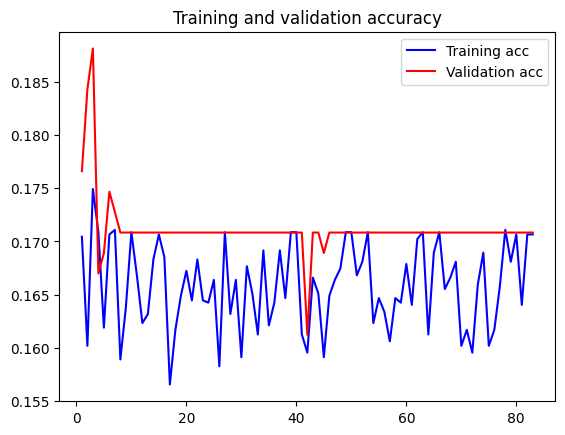

<Figure size 640x480 with 0 Axes>

In [82]:
epochs = range(1, len(save_metric.accuracy) + 1)
plt.plot(epochs, save_metric.accuracy, 'b', label='Training acc')
plt.plot(epochs, save_metric.val_accuracy, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

<Figure size 640x480 with 0 Axes>

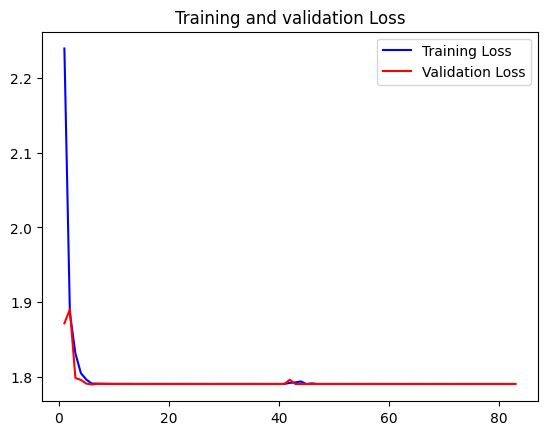

<Figure size 640x480 with 0 Axes>

In [83]:
epochs = range(1, len(save_metric.loss) + 1)
plt.plot(epochs, save_metric.loss, 'b', label='Training Loss')
plt.plot(epochs, save_metric.val_loss, 'r', label='Validation Loss')
plt.title('Training and validation Loss')
plt.legend()
plt.figure()

<Figure size 640x480 with 0 Axes>

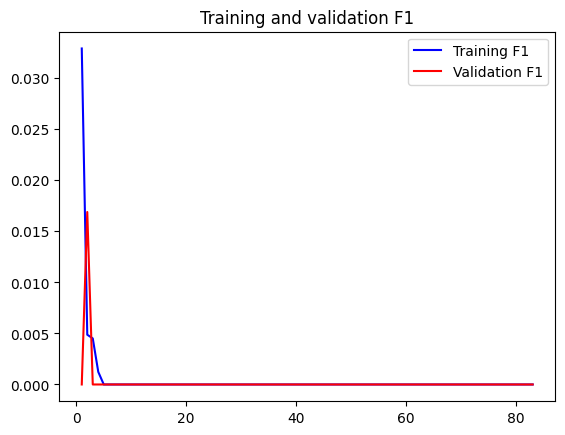

<Figure size 640x480 with 0 Axes>

In [84]:
epochs=range(1,len(save_metric.f1)+1)
plt.plot(epochs,save_metric.f1,'b',label='Training F1')
plt.plot(epochs,save_metric.val_f1,'r',label='Validation F1')
plt.title('Training and validation F1')
plt.legend()
plt.figure()

In [85]:
# reload the best model
filepath="/content/drive/MyDrive/Kaggle_ds/paper_1d_normal.best.hdf5"

model.load_weights(filepath)

# evaluate model on test data

from sklearn.metrics import classification_report

y_pred = model.predict(X_test_normalized, batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

y_test_bool = np.argmax(y_test_oe, axis=1)
print(classification_report(y_test_bool, y_pred_bool))

140/140 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

           0       0.07      0.00      0.01       382
           1       0.17      0.80      0.28       381
           2       0.00      0.00      0.00       381
           3       0.18      0.20      0.19       382
           4       0.00      0.00      0.00       326
           5       0.06      0.01      0.01       381

    accuracy                           0.17      2233
   macro avg       0.08      0.17      0.08      2233
weighted avg       0.08      0.17      0.08      2233



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


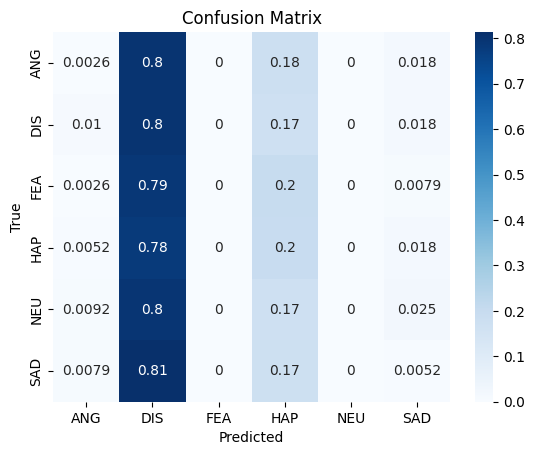

In [86]:
# Label ANG mapped to 0
# Label DIS mapped to 1
# Label FEA mapped to 2
# Label HAP mapped to 3
# Label NEU mapped to 4
# Label SAD mapped to 5

# confusion matrix for test data

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test_bool, y_pred_bool)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, cmap='Blues',xticklabels=['ANG','DIS','FEA','HAP','NEU','SAD'],yticklabels=['ANG','DIS','FEA','HAP','NEU','SAD'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# LDA

In [57]:
lda = LDA(n_components=5)
lda.fit(X_train_normalized, y_train)

LinearDiscriminantAnalysis(n_components=5)

In [58]:
X_train_normalized = lda.transform(X_train_normalized)
X_val_normalized = lda.transform(X_val_normalized)
X_test_normalized = lda.transform(X_test_normalized)

## Training

In [72]:
# train model
model = create_model()
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=20, min_lr=0.000001)
save_metric = myCallback()
es = EarlyStopping(monitor='val_accuracy', patience=80)
filepath="/content/drive/MyDrive/Kaggle_ds/paper_1d.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

tensorflow.convert_to_tensor(X_train_normalized, dtype=tensorflow.float32)
cnn_results=model.fit(X_train_normalized, y_train_oe,  
                      batch_size=64,
                      epochs=1000,
                      validation_data = (X_val_normalized,y_val_oe),
                      callbacks=[lr_reduce,checkpoint,es,save_metric])

Epoch 1/1000
74/74 [==============================] - ETA: 0s - loss: 2.3032 - accuracy: 0.1657 - get_f1: 0.0473
Epoch 1: val_accuracy improved from -inf to 0.17083, saving model to /content/drive/MyDrive/Kaggle_ds/paper_1d.best.hdf5
74/74 [==============================] - 89s 119ms/step - loss: 2.3032 - accuracy: 0.1657 - get_f1: 0.0473 - val_loss: 1.7953 - val_accuracy: 0.1708 - val_get_f1: 0.0000e+00 - lr: 0.0010
Epoch 2/1000
72/74 [============================>.] - ETA: 0s - loss: 1.9992 - accuracy: 0.1691 - get_f1: 0.0199
Epoch 2: val_accuracy did not improve from 0.17083
74/74 [==============================] - 2s 28ms/step - loss: 1.9973 - accuracy: 0.1689 - get_f1: 0.0197 - val_loss: 1.8059 - val_accuracy: 0.1708 - val_get_f1: 0.0034 - lr: 0.0010
Epoch 3/1000
73/74 [============================>.] - ETA: 0s - loss: 1.9642 - accuracy: 0.1685 - get_f1: 0.0081
Epoch 3: val_accuracy did not improve from 0.17083
74/74 [==============================] - 2s 25ms/step - loss: 1.9642 -

## Results

<Figure size 640x480 with 0 Axes>

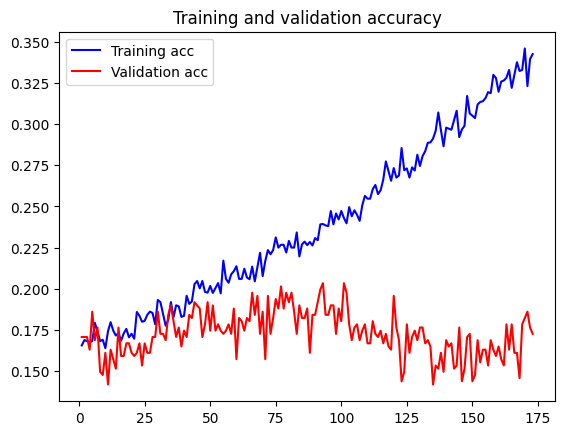

<Figure size 640x480 with 0 Axes>

In [73]:
epochs = range(1, len(save_metric.accuracy) + 1)
plt.plot(epochs, save_metric.accuracy, 'b', label='Training acc')
plt.plot(epochs, save_metric.val_accuracy, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

<Figure size 640x480 with 0 Axes>

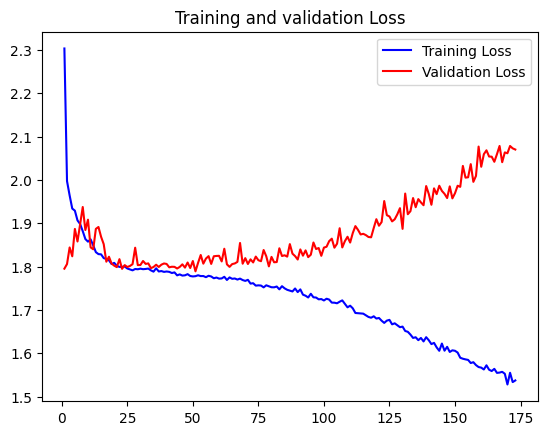

<Figure size 640x480 with 0 Axes>

In [74]:
epochs = range(1, len(save_metric.loss) + 1)
plt.plot(epochs, save_metric.loss, 'b', label='Training Loss')
plt.plot(epochs, save_metric.val_loss, 'r', label='Validation Loss')
plt.title('Training and validation Loss')
plt.legend()
plt.figure()

<Figure size 640x480 with 0 Axes>

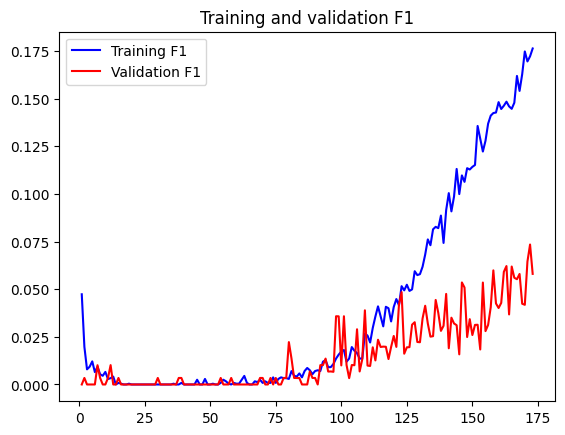

<Figure size 640x480 with 0 Axes>

In [75]:
epochs=range(1,len(save_metric.f1)+1)
plt.plot(epochs,save_metric.f1,'b',label='Training F1')
plt.plot(epochs,save_metric.val_f1,'r',label='Validation F1')
plt.title('Training and validation F1')
plt.legend()
plt.figure()

In [76]:
# reload the best model
filepath="/content/drive/MyDrive/Kaggle_ds/paper_1d.best.hdf5"

model.load_weights(filepath)

# evaluate model on test data

from sklearn.metrics import classification_report

y_pred = model.predict(X_test_normalized, batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

y_test_bool = np.argmax(y_test_oe, axis=1)
print(classification_report(y_test_bool, y_pred_bool))

140/140 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0       0.16      0.41      0.23       382
           1       0.13      0.03      0.05       381
           2       0.15      0.15      0.15       381
           3       0.15      0.09      0.12       382
           4       0.12      0.02      0.03       326
           5       0.17      0.24      0.20       381

    accuracy                           0.16      2233
   macro avg       0.15      0.16      0.13      2233
weighted avg       0.15      0.16      0.13      2233



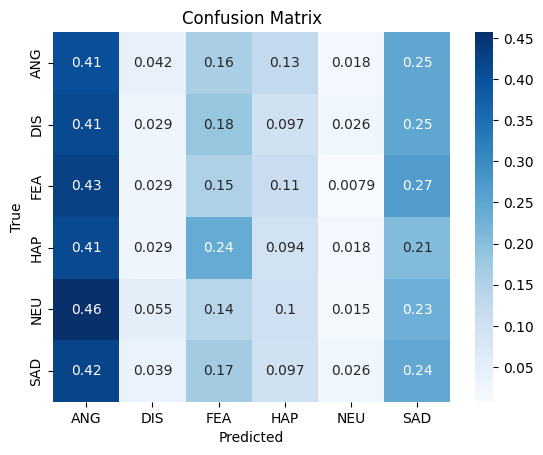

In [77]:
# Label ANG mapped to 0
# Label DIS mapped to 1
# Label FEA mapped to 2
# Label HAP mapped to 3
# Label NEU mapped to 4
# Label SAD mapped to 5

# confusion matrix for test data

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test_bool, y_pred_bool)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, cmap='Blues',xticklabels=['ANG','DIS','FEA','HAP','NEU','SAD'],yticklabels=['ANG','DIS','FEA','HAP','NEU','SAD'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# PCA

In [99]:
pca = PCA(n_components=10)
pca.fit(X_train_normalized)
print(sum(pca.explained_variance_ratio_))

0.9999999993119439


In [100]:
X_train_normalized = lda.transform(X_train_normalized)
X_val_normalized = lda.transform(X_val_normalized)
X_test_normalized = lda.transform(X_test_normalized)

## Training

In [101]:
# train model
model = create_model()
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=20, min_lr=0.000001)
save_metric = myCallback()
es = EarlyStopping(monitor='val_accuracy', patience=80)
filepath="/content/drive/MyDrive/Kaggle_ds/paper_1d_pca.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

tensorflow.convert_to_tensor(X_train_normalized, dtype=tensorflow.float32)
cnn_results=model.fit(X_train_normalized, y_train_oe,  
                      batch_size=64,
                      epochs=1000,
                      validation_data = (X_val_normalized,y_val_oe),
                      callbacks=[lr_reduce,checkpoint,es,save_metric])

Epoch 1/1000
74/74 [==============================] - ETA: 0s - loss: 2.2512 - accuracy: 0.1566 - get_f1: 0.0305
Epoch 1: val_accuracy improved from -inf to 0.17274, saving model to /content/drive/MyDrive/Kaggle_ds/paper_1d_pca.best.hdf5
74/74 [==============================] - 14s 72ms/step - loss: 2.2512 - accuracy: 0.1566 - get_f1: 0.0305 - val_loss: 1.7990 - val_accuracy: 0.1727 - val_get_f1: 0.0000e+00 - lr: 0.0010
Epoch 2/1000
72/74 [============================>.] - ETA: 0s - loss: 1.9541 - accuracy: 0.1678 - get_f1: 0.0127
Epoch 2: val_accuracy did not improve from 0.17274
74/74 [==============================] - 2s 30ms/step - loss: 1.9557 - accuracy: 0.1677 - get_f1: 0.0123 - val_loss: 1.8061 - val_accuracy: 0.1708 - val_get_f1: 0.0000e+00 - lr: 0.0010
Epoch 3/1000
72/74 [============================>.] - ETA: 0s - loss: 1.9524 - accuracy: 0.1753 - get_f1: 0.0113
Epoch 3: val_accuracy did not improve from 0.17274
74/74 [==============================] - 2s 27ms/step - loss: 1

## Results

<Figure size 640x480 with 0 Axes>

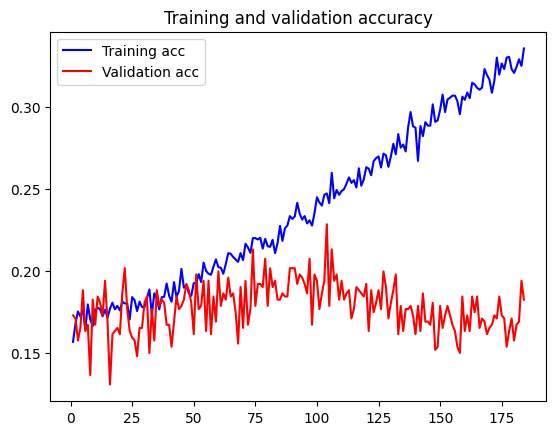

<Figure size 640x480 with 0 Axes>

In [107]:
epochs = range(1, len(save_metric.accuracy) + 1)
plt.plot(epochs, save_metric.accuracy, 'b', label='Training acc')
plt.plot(epochs, save_metric.val_accuracy, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

<Figure size 640x480 with 0 Axes>

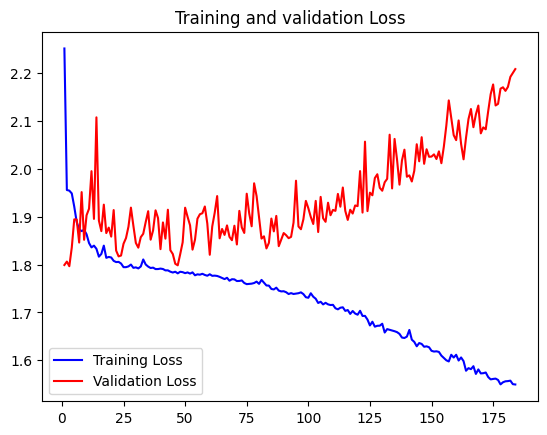

<Figure size 640x480 with 0 Axes>

In [108]:
epochs = range(1, len(save_metric.loss) + 1)
plt.plot(epochs, save_metric.loss, 'b', label='Training Loss')
plt.plot(epochs, save_metric.val_loss, 'r', label='Validation Loss')
plt.title('Training and validation Loss')
plt.legend()
plt.figure()

<Figure size 640x480 with 0 Axes>

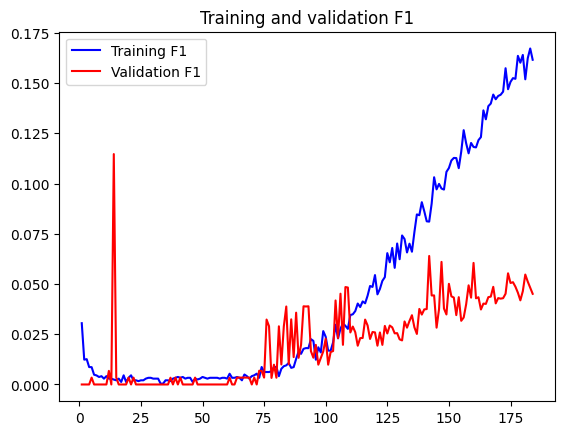

<Figure size 640x480 with 0 Axes>

In [109]:
epochs=range(1,len(save_metric.f1)+1)
plt.plot(epochs,save_metric.f1,'b',label='Training F1')
plt.plot(epochs,save_metric.val_f1,'r',label='Validation F1')
plt.title('Training and validation F1')
plt.legend()
plt.figure()

In [110]:
# reload the best model
filepath="/content/drive/MyDrive/Kaggle_ds/paper_1d_pca.best.hdf5"

model.load_weights(filepath)

# evaluate model on test data

from sklearn.metrics import classification_report

y_pred = model.predict(X_test_normalized, batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

y_test_bool = np.argmax(y_test_oe, axis=1)
print(classification_report(y_test_bool, y_pred_bool))

140/140 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.15      0.42      0.23       382
           1       0.16      0.19      0.18       381
           2       0.13      0.05      0.07       381
           3       0.20      0.14      0.17       382
           4       0.11      0.03      0.05       326
           5       0.18      0.10      0.13       381

    accuracy                           0.16      2233
   macro avg       0.16      0.16      0.14      2233
weighted avg       0.16      0.16      0.14      2233



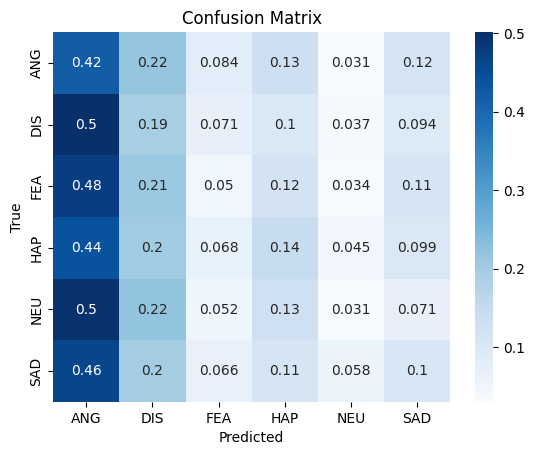

In [111]:
# Label ANG mapped to 0
# Label DIS mapped to 1
# Label FEA mapped to 2
# Label HAP mapped to 3
# Label NEU mapped to 4
# Label SAD mapped to 5

# confusion matrix for test data

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test_bool, y_pred_bool)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, cmap='Blues',xticklabels=['ANG','DIS','FEA','HAP','NEU','SAD'],yticklabels=['ANG','DIS','FEA','HAP','NEU','SAD'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()